**Задача**: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту. \
Для анализа риска создается модель, предсказывающая возможность попадания водителя в аварию. Модель бинарной классификации. Отбираются и анализируются основные факторы, влияющие на модель.

## Подключение к базе. Загрузка таблиц sql

Импорт необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
import lightgbm as gbm
from pprint import pprint
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

Создание словаря с параметрами подключения к базе данных

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-science-vehicle-db' # название базы данных
}

Создание строки подключения

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

создать "движок"

In [4]:
engine = create_engine(connection_string)

In [5]:
def query_execution(query: str):
    try:
        data = pd.read_sql_query(query, con = engine) 
    except Exception as e:
        print(e)
        return None
    return data

Проверка таблиц из описания к задаче:

In [6]:
query = '''
SELECT * FROM collisions;
'''
data_collisions = query_execution(query)
print(data_collisions.head())
data_collisions.to_csv('data_collisions.csv')

   case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0           0.0    cloudy       highway     small damage            2   
1           1.0     clear          None     small damage            1   
2           1.0     clear          None          scratch            2   
3           1.0     clear          None          scratch            2   
4           1.0     clear          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   vehicle code violation       unsafe lane change         s

In [7]:
query = '''
SELECT * FROM parties;
'''
data_parties = query_execution(query)
print(data_parties.head())
data_parties.to_csv('data_parties.csv')

   id  case_id  party_number   party_type  at_fault  insurance_premium  \
0  22  3899454             1   road signs         1               29.0   
1  23  3899454             2   road signs         0                7.0   
2  29  3899462             2          car         0               21.0   
3  31  3899465             2   road signs         0               24.0   
4  41  3899478             2  road bumper         0                NaN   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None               0.0  
1  had not been drinking                None               0.0  
2  had not been drinking                None               0.0  
3  had not been drinking                None               0.0  
4         not applicable      not applicable               0.0  


In [8]:
query = '''
SELECT * FROM vehicles;
'''
data_vehicles = query_execution(query)
print(data_vehicles.head())
data_vehicles.to_csv('data_vehicles.csv')

        id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   
3  1175717  5305033             3        sedan                 auto   
4  1175722  5305034             2        sedan                 auto   

   vehicle_age  
0          3.0  
1          3.0  
2          3.0  
3          5.0  
4          5.0  


In [9]:
query = '''
SELECT * FROM case_ids;
'''
data_ids = query_execution(query)
print(data_collisions.head())
data_ids.to_csv('data_ids.csv')

   case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0           0.0    cloudy       highway     small damage            2   
1           1.0     clear          None     small damage            1   
2           1.0     clear          None          scratch            2   
3           1.0     clear          None          scratch            2   
4           1.0     clear          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   vehicle code violation       unsafe lane change         s

## Проведение первичного исследования таблиц

Для удобства исследование датасетов - через вызов вспомогательной функции:

In [10]:
def primary_research(dataset):
    print('----------------------------')
    print('голова датасета:')
    dataset.head()
    print('----------------------------')
    print('общая информация о датасете:')
    dataset.info()
    print('----------------------------')

In [11]:
primary_research(data_collisions)

----------------------------
голова датасета:
----------------------------
общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11

In [12]:
primary_research(data_parties)

----------------------------
голова датасета:
----------------------------
общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB
----------------------------


In [13]:
primary_research(data_vehicles)

----------------------------
голова датасета:
----------------------------
общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB
----------------------------


In [14]:
primary_research(data_ids)

----------------------------
голова датасета:
----------------------------
общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB
----------------------------


##  Проведение статистического анализа факторов ДТП

<b>1. В какие месяцы происходит наибольшее количество аварий за весь период наблюдений (таблица collisions). </b>\
Фактически надо создать сводную таблицу, столбцы которой - годы из таблицы, строки - месяцы, значения - количество ДТП.

Сначала необходимо выяснить, по каким годам хранится статистика ДТП в таблице коллизий:

In [15]:
query = '''
SELECT DISTINCT CAST(EXTRACT(YEAR FROM collisions.collision_date) AS integer) AS YY
FROM collisions
ORDER BY YY;
'''

In [16]:
data_years = query_execution(query)
print(data_years.head())

     yy
0  2009
1  2010
2  2011
3  2012
4  2013


In [17]:
query = '''
WITH collisions_2009 AS
(
    SELECT 
    CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer) AS month,
    COUNT(case_id) as collisions_month_2009
    FROM collisions
    WHERE CAST(EXTRACT(YEAR FROM collisions.collision_date) AS integer) = 2009
    GROUP BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
    ORDER BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
),
collisions_2010 AS
(
    SELECT 
    CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer) AS month,
    COUNT(case_id) as collisions_month_2010
    FROM collisions
    WHERE CAST(EXTRACT(YEAR FROM collisions.collision_date) AS integer) = 2010
    GROUP BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
    ORDER BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
),
collisions_2011 AS
(
    SELECT 
    CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer) AS month,
    COUNT(case_id) as collisions_month_2011
    FROM collisions
    WHERE CAST(EXTRACT(YEAR FROM collisions.collision_date) AS integer) = 2011
    GROUP BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
    ORDER BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
),
collisions_2012 AS
(
    SELECT 
    CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer) AS month,
    COUNT(case_id) as collisions_month_2012
    FROM collisions
    WHERE CAST(EXTRACT(YEAR FROM collisions.collision_date) AS integer) = 2012
    GROUP BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
    ORDER BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
),
collisions_2013 AS
(
    SELECT 
    CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer) AS month,
    COUNT(case_id) as collisions_month_2013
    FROM collisions
    WHERE CAST(EXTRACT(YEAR FROM collisions.collision_date) AS integer) = 2013
    GROUP BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
    ORDER BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
),
collisions_2020 AS
(
    SELECT 
    CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer) AS month,
    COUNT(case_id) as collisions_month_2020
    FROM collisions
    WHERE CAST(EXTRACT(YEAR FROM collisions.collision_date) AS integer) = 2020
    GROUP BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
    ORDER BY CAST(EXTRACT(MONTH FROM collisions.collision_date) AS integer)
)
SELECT
collisions_2009.month, 
collisions_2009.collisions_month_2009 AS coll_2009, 
collisions_2010.collisions_month_2010 AS coll_2010,
collisions_2011.collisions_month_2011 AS coll_2011,
collisions_2012.collisions_month_2012 AS coll_2012,
collisions_2013.collisions_month_2013 AS coll_2013,
collisions_2020.collisions_month_2020 AS coll_2020

FROM
collisions_2009 
LEFT JOIN collisions_2010 ON collisions_2009.month = collisions_2010.month
LEFT JOIN collisions_2011 ON collisions_2009.month = collisions_2011.month
LEFT JOIN collisions_2012 ON collisions_2009.month = collisions_2012.month
LEFT JOIN collisions_2013 ON collisions_2009.month = collisions_2013.month
LEFT JOIN collisions_2020 ON collisions_2009.month = collisions_2020.month

ORDER BY month;
'''

In [18]:
data_years_month_collisions = query_execution(query)
print(data_years_month_collisions)

    month  coll_2009  coll_2010  coll_2011  coll_2012  coll_2013  coll_2020
0       1      35062      32892      31926      32020      144.0        NaN
1       2      34480      31918      31975      30377      108.0        NaN
2       3      36648      35803      34585      32498       46.0        1.0
3       4      35239      34416      31377      29143        5.0        NaN
4       5      36916      34862      33370      25168        NaN        NaN
5       6      34202      33367      31962       3062        1.0        NaN
6       7      35161      33645      33029        390        1.0        1.0
7       8      34508      34620      34339        622        NaN        NaN
8       9      35555      34957      34137        510        NaN        NaN
9      10      37835      37480      36618        304        NaN        NaN
10     11      34562      35460      34495        253        NaN        NaN
11     12      36060      37070      34615        200        NaN        NaN


Из таблицы видно, что в целом количество аварий по месяцам каждого года находится примерно на одном уровне. В 2010-2011гг.аварий в среднем меньше, чем в 2009. По 2012, 2013, 2020 гг. данные неполные.

In [19]:
data_years_month_collisions['coll_2009']

0     35062
1     34480
2     36648
3     35239
4     36916
5     34202
6     35161
7     34508
8     35555
9     37835
10    34562
11    36060
Name: coll_2009, dtype: int64

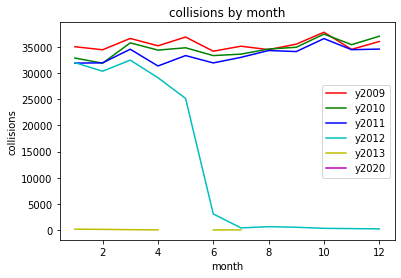

In [20]:
# Data for plotting

coll2009 = data_years_month_collisions['coll_2009']
coll2010 = data_years_month_collisions['coll_2010']
coll2011 = data_years_month_collisions['coll_2011']
coll2012 = data_years_month_collisions['coll_2012']
coll2013 = data_years_month_collisions['coll_2013']
coll2020 = data_years_month_collisions['coll_2020']
  
# Plotting both the curves simultaneously
plt.plot(data_years_month_collisions['month'], coll2009, color='r', label='y2009')
plt.plot(data_years_month_collisions['month'], coll2010, color='g', label='y2010')
plt.plot(data_years_month_collisions['month'], coll2011, color='b', label='y2011')
plt.plot(data_years_month_collisions['month'], coll2012, color='c', label='y2012')
plt.plot(data_years_month_collisions['month'], coll2013, color='y', label='y2013')
plt.plot(data_years_month_collisions['month'], coll2020, color='m', label='y2020')

plt.xlabel("month")
plt.ylabel("collisions")
plt.title("collisions by month")

plt.legend()

plt.show()

<b>2. Анализ серьёзности повреждений транспортного средства исходя из состояния дороги в момент ДТП (связь collisions и parties). </b>\
Здесь сводная таблица на основе таблицы коллизий. По строкам - степень повреждения, по столбцам - состояние дороги. Значение - количество ДТП. Непонятно, зачем связывать ее с таблицей parties.

In [21]:
query = '''
WITH collisions_dry AS
(
    SELECT collision_damage, COUNT(case_id) 
    FROM collisions
    WHERE road_surface = 'dry'
    GROUP BY collision_damage
),
collisions_wet AS
(
    SELECT collision_damage, COUNT(case_id) 
    FROM collisions
    WHERE road_surface = 'wet'
    GROUP BY collision_damage
),
collisions_slippery AS
(
    SELECT collision_damage, COUNT(case_id) 
    FROM collisions
    WHERE road_surface = 'slippery'
    GROUP BY collision_damage
),
collisions_none AS
(
    SELECT collision_damage, COUNT(case_id) 
    FROM collisions
    WHERE road_surface = 'none'
    GROUP BY collision_damage
),
collisions_snowy AS
(
    SELECT collision_damage, COUNT(case_id) 
    FROM collisions
    WHERE road_surface = 'snowy'
    GROUP BY collision_damage
)
SELECT 
collisions_dry.collision_damage, 
collisions_dry.count AS collision_dry,
collisions_wet.count AS collision_wet,
collisions_slippery.count AS collision_slippery,
collisions_none.count AS collision_none,
collisions_snowy.count AS collision_snowy
FROM collisions_dry
LEFT JOIN collisions_wet ON collisions_dry.collision_damage = collisions_wet.collision_damage
LEFT JOIN collisions_slippery ON collisions_dry.collision_damage = collisions_slippery.collision_damage
LEFT JOIN collisions_none ON collisions_dry.collision_damage = collisions_none.collision_damage
LEFT JOIN collisions_snowy ON collisions_dry.collision_damage = collisions_snowy.collision_damage;
'''

In [22]:
data_collisions_surface = query_execution(query)
print(data_collisions_surface)

  collision_damage  collision_dry  collision_wet  collision_slippery  \
0            fatal           9823            857                  12   
1    middle damage         151015          13190                 238   
2          scratch         307963          33301                 308   
3    severe damage          27827           2470                  64   
4     small damage         745398          86418                 762   

  collision_none  collision_snowy  
0           None               46  
1           None              762  
2           None             1259  
3           None              157  
4           None             5037  


Самое большое количество ДТП - на сухой поверхности дороги.

<b>3. Поиск самых частых причины ДТП (таблица parties)</b> \
Основные факторы (т.е. причины ДТП) в таблице коллизий - primary_collision_factor \
Распределение количества ДТП из таблицы коллизий по типам ДТП:

In [23]:
query = '''
SELECT 
primary_collision_factor,
COUNT(case_id)
FROM
collisions
GROUP BY primary_collision_factor;
'''

In [24]:
data_collisions_surface = query_execution(query)
print(data_collisions_surface)

  primary_collision_factor    count
0              fell asleep      117
1   other improper driving     8470
2        other than driver    29780
3                  unknown    37014
4   vehicle code violation  1316453
5                     None     8166


<b>Еще задачи:</b> \
Все задачи разделил на группы: 
1. Анализ причин ДТП в зависимости от состояния транспортного средства 
2. Анализ причин ДТП в зависимости от факторов внешней среды 
3. Анализ причин ДТП в зависимости от участников ДТП 

<b>1. Анализ причин ДТП в зависимости от состояния транспортного средства </b> \
Необходимо объединить таблицу коллизий и таблицу vehicles по case_id. Рассмотреть распределение количества аварий в зависимости от  
1.1 возраста автомобиля (основное), \
1.2 типа трансмиссии, \
1.3 типа автомобиля.

<b>2. Анализ причин ДТП в зависимости от состояния внешней среды </b> \
Необходимо использовать таблицу коллизий. Рассмотреть распределение количества аварий в зависимости от  
2.1 типа освещения, \
2.2 типа дороги, \
2.3 состояния дороги, \
2.4 погоды и др.

В рамках поставленных задач я решил сделать хитмэп с количеством аварий по дням недели в 2009 году (в 2009 данные полные). Можно в принципе и по другому году, и за несколько лет, и по всем данным. Но поскольку в 2012-2020 данные не полные, бююсь, к искажению картины может привести, если по всем данным делать. \
Использовал sql и pandas, чтобы построить сводную таблицу. С одним только sql запрос сильно усложняется.

In [25]:
query = '''
SELECT 
CAST(EXTRACT(day FROM collision_date) AS integer) AS day,
CAST(EXTRACT(MONTH FROM collision_date) AS integer) AS month,
COUNT(case_id)
FROM collisions
WHERE CAST(EXTRACT(YEAR FROM collision_date) AS integer) = 2009
GROUP BY 
CAST(EXTRACT(day FROM collision_date) AS integer),
CAST(EXTRACT(MONTH FROM collision_date) AS integer)
'''

In [26]:
data_collisions_day_month = query_execution(query)
print(data_collisions_day_month)

     day  month  count
0      1      1   1001
1      1      2    991
2      1      3   1035
3      1      4   1284
4      1      5   1636
..   ...    ...    ...
360   31      5    952
361   31      7   1271
362   31      8   1211
363   31     10   1172
364   31     12    997

[365 rows x 3 columns]


In [27]:
data_pivot = data_collisions_day_month.pivot_table(index = 'month', columns = 'day', values = 'count')

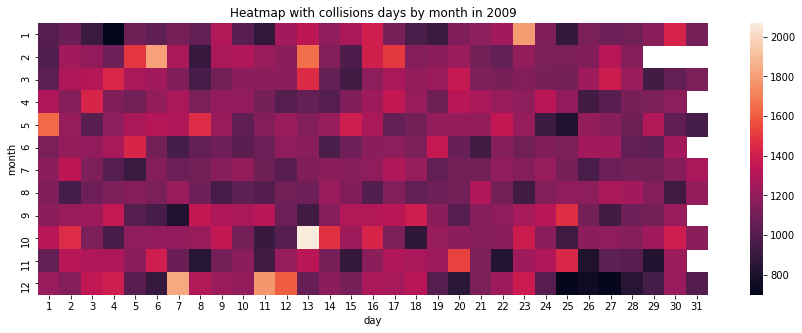

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Heatmap with collisions days by month in 2009')
sns.heatmap(data_pivot);

Тут трудно выявить какие-либо тенденции. Понамешано.

То же самое для количества аварий по часам дня

In [29]:
query = '''
SELECT 
CAST(EXTRACT(day FROM collision_date) AS integer) AS day,
CAST(EXTRACT(HOUR FROM collision_time) AS integer) AS hour,
COUNT(case_id)
FROM collisions
WHERE CAST(EXTRACT(YEAR FROM collision_date) AS integer) = 2009
GROUP BY 
CAST(EXTRACT(day FROM collision_date) AS integer),
CAST(EXTRACT(HOUR FROM collision_time) AS integer)
'''

In [30]:
data_collisions_day_hour = query_execution(query)
print(data_collisions_day_hour)

     day  hour  count
0      1   0.0    340
1      1   1.0    399
2      1   2.0    412
3      1   3.0    245
4      1   4.0    207
..   ...   ...    ...
770   31  20.0    320
771   31  21.0    273
772   31  22.0    291
773   31  23.0    226
774   31   NaN     82

[775 rows x 3 columns]


In [31]:
data_pivot = data_collisions_day_hour.pivot_table(index = 'day', columns = 'hour', values = 'count')

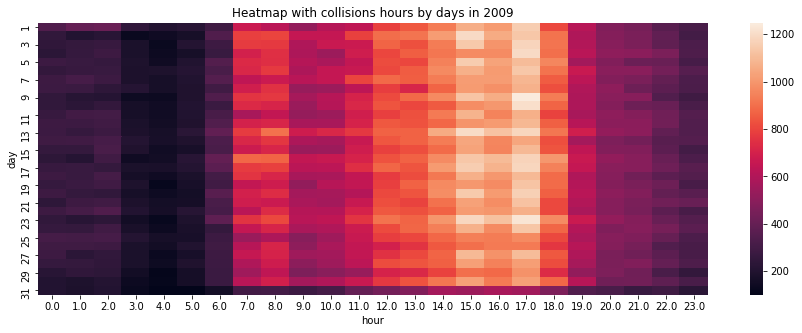

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Heatmap with collisions hours by days in 2009')
sns.heatmap(data_pivot);

А вот тут ясно видно, что в дневные часы аварий больше, чем в ночные. Больше всего с 15 до 17 часов дня. Час пик видимо.

<b>3. Анализ причин ДТП в зависимости от участников ДТП </b> \
Здесь не требуется объединять таблицу коллизий и таблицу parties через case_ids (многие ко многим). Аварии как case_ids уже присутствуют в parties. Рассмотреть распределение количества аварий (используя DISTINCT) в зависимости от \
3.1 фактора алкогольного опъянения, \
3.2 воздействия лекарств, \
3.3 пользования мобильным телефоном.

Распределение аварий в зависимости от фактора алкогольного опъянения

In [33]:
query = '''
SELECT 
COUNT(DISTINCT case_id),
party_sobriety
FROM
parties
GROUP BY party_sobriety;
'''
data_collisions_alcohol = query_execution(query)
print(data_collisions_alcohol)

     count                          party_sobriety
0    20975   had been drinking, impairment unknown
1    15967  had been drinking, not under influence
2   111559      had been drinking, under influence
3  1185724                   had not been drinking
4   224079                      impairment unknown
5   129640                          not applicable
6    57946                                    None


Распределение аварий в зависимости от воздействия лекарств

In [34]:
query = '''
SELECT 
COUNT(DISTINCT case_id),
party_drug_physical
FROM
parties
GROUP BY party_drug_physical;
'''
data_collisions_drug_factor = query_execution(query)
print(data_collisions_drug_factor)

     count    party_drug_physical
0   224079                      G
1     4179  impairment - physical
2   129640         not applicable
3    12627        sleepy/fatigued
4    13117   under drug influence
5  1287180                   None


Распределение аварий в зависимости от пользования мобильником:

In [35]:
query = '''
SELECT 
COUNT(DISTINCT case_id),
cellphone_in_use
FROM
parties
GROUP BY cellphone_in_use;
'''
data_collisions_cellphone = query_execution(query)
print(data_collisions_cellphone)

     count  cellphone_in_use
0  1179284               0.0
1    32506               1.0
2   306134               NaN


## Модель для оценки водительского риска

Данные, содержащиеся в таблицах базы данных, предлагается разбить на 2 группы пре- и пост- факторы. Пре-факторы - те, которыми мы можем оперировать, которые становятся нам известными, когда человек садится в машину и выбирает маршрут (например, возраст авто, тип коробки, погода, состояние покрытия. По пъянству - спорно (кто же признается?), но я все равно и его включил (самый влияющий фактор оказался!). 

Запрос для построения датасета, по которому будем строить модель. \
Объединение всех таблиц, с выбором необходимых факторов, за 2012 год, где участвует машина.

In [36]:
query = '''
SELECT
vehicles.vehicle_type,
vehicles.vehicle_transmission,
vehicles.vehicle_age,
collisions.county_city_location,
collisions.county_location,
collisions.weather_1,
collisions.location_type,
collisions.road_surface,
collisions.road_condition_1,
collisions.lighting,
collisions.control_device,
collisions.collision_date,
collisions.collision_time,
parties.at_fault,
parties.party_sobriety,
parties.party_drug_physical,
parties.cellphone_in_use
FROM
case_ids 
INNER JOIN vehicles ON case_ids.case_id = vehicles.case_id
INNER JOIN collisions ON case_ids.case_id = collisions.case_id
INNER JOIN parties ON case_ids.case_id = parties.case_id
WHERE collisions.collision_damage != 'scratch' 
AND CAST(EXTRACT(YEAR FROM collisions.collision_date) AS INTEGER) = '2012' 
AND parties.party_type = 'car'
AND vehicles.party_number = parties.party_number;
'''

In [37]:
data = query_execution(query)
data.head()

,vehicle_type,vehicle_transmission,vehicle_age,county_city_location,county_location,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,at_fault,party_sobriety,party_drug_physical,cellphone_in_use
0,sedan,auto,3.0,3010,orange,clear,None,dry,normal,daylight,none,2012-04-17,17:09:00,1,impairment unknown,G,NaN
1,sedan,manual,3.0,4806,solano,cloudy,ramp,dry,normal,daylight,none,2012-01-02,15:32:00,1,had not been drinking,None,0.0
2,sedan,manual,NaN,3001,orange,clear,None,dry,normal,dark with street lights,functioning,2012-01-01,22:06:00,0,had not been drinking,None,0.0
3,sedan,manual,3.0,3906,san joaquin,fog,highway,dry,normal,dark with no street lights,functioning,2012-01-01,03:00:00,1,had not been drinking,None,0.0
4,sedan,manual,4.0,4200,santa barbara,clear,None,dry,normal,dusk or dawn,none,2012-01-02,17:08:00,1,had not been drinking,None,0.0


Первичная информация о получившемся датасете. Почти все признаки - категориальные. Только возраст - числовой. \
Таргетом будет признак 'at_fault'.

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vehicle_type          56248 non-null  object 
 1   vehicle_transmission  55389 non-null  object 
 2   vehicle_age           54554 non-null  float64
 3   county_city_location  56248 non-null  object 
 4   county_location       56248 non-null  object 
 5   weather_1             56080 non-null  object 
 6   location_type         25932 non-null  object 
 7   road_surface          55900 non-null  object 
 8   road_condition_1      55999 non-null  object 
 9   lighting              56094 non-null  object 
 10  control_device        56033 non-null  object 
 11  collision_date        56248 non-null  object 
 12  collision_time        56160 non-null  object 
 13  at_fault              56248 non-null  int64  
 14  party_sobriety        55376 non-null  object 
 15  party_drug_physical

Первичный анализ указывает на наличие пропуской в признаках. Пропуски меняю на 'not_stated'.

In [39]:
data['vehicle_age'].unique()

array([  3.,  nan,   4.,   1.,   8.,  12.,   7.,  11.,   6.,  13.,   5.,
         9.,   2.,  10.,   0.,  17.,  14.,  16.,  15., 161.,  19.])

In [40]:
data['vehicle_transmission'].unique()

array(['auto', 'manual', None], dtype=object)

In [41]:
data['vehicle_transmission'] = data['vehicle_transmission'].fillna('not_stated')

In [42]:
data['weather_1'] = data['weather_1'].fillna('not_stated')

In [43]:
data['location_type'] = data['location_type'].fillna('not_stated')

In [44]:
data['road_surface'] = data['road_surface'].fillna('not_stated')

In [45]:
data['road_condition_1'] = data['road_condition_1'].fillna('not_stated')

In [46]:
data['lighting'] = data['lighting'].fillna('not_stated')

In [47]:
data.loc[data['control_device'] == 'none', 'control_device'] = 'not_stated'

In [48]:
data['control_device'] = data['control_device'].fillna('not_stated')

In [49]:
data['party_sobriety'] = data['party_sobriety'].fillna('not_stated')

In [50]:
data['party_drug_physical'] = data['party_drug_physical'].fillna('not_stated')

In [51]:
data['cellphone_in_use'] = data['cellphone_in_use'].fillna('not_stated')

In [52]:
data.dropna(subset = ['vehicle_age'], inplace = True)

In [53]:
data.dropna(subset = ['collision_time'], inplace = True)

In [54]:
data.reset_index(inplace = True)

Результат:

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54470 entries, 0 to 54469
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 54470 non-null  int64  
 1   vehicle_type          54470 non-null  object 
 2   vehicle_transmission  54470 non-null  object 
 3   vehicle_age           54470 non-null  float64
 4   county_city_location  54470 non-null  object 
 5   county_location       54470 non-null  object 
 6   weather_1             54470 non-null  object 
 7   location_type         54470 non-null  object 
 8   road_surface          54470 non-null  object 
 9   road_condition_1      54470 non-null  object 
 10  lighting              54470 non-null  object 
 11  control_device        54470 non-null  object 
 12  collision_date        54470 non-null  object 
 13  collision_time        54470 non-null  object 
 14  at_fault              54470 non-null  int64  
 15  party_sobriety     

Нулей и единиц в таргете практически поровну (сбалансированные).

In [56]:
data.groupby(['at_fault']).count()

,index,vehicle_type,vehicle_transmission,vehicle_age,county_city_location,county_location,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,party_sobriety,party_drug_physical,cellphone_in_use
at_fault,,,,,,,,,,,,,,,,,
0,26999,26999,26999,26999,26999,26999,26999,26999,26999,26999,26999,26999,26999,26999,26999,26999,26999
1,27471,27471,27471,27471,27471,27471,27471,27471,27471,27471,27471,27471,27471,27471,27471,27471,27471


Дату и время ДТП превращаю в день, месяц, час:

In [57]:
data['collision_date'] = pd.to_datetime(data['collision_date'])

In [58]:
data['collision_time'] = pd.to_datetime(data['collision_time'], format='%H:%M:%S')

In [59]:
data['month'] = data['collision_date'].dt.month

In [60]:
data['day'] = data['collision_date'].dt.day

In [61]:
data['hour'] = data['collision_time'].dt.hour

In [62]:
data.head()

,index,vehicle_type,vehicle_transmission,vehicle_age,county_city_location,county_location,weather_1,location_type,road_surface,road_condition_1,...,control_device,collision_date,collision_time,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,month,day,hour
0,0,sedan,auto,3.0,3010,orange,clear,not_stated,dry,normal,...,not_stated,2012-04-17,1900-01-01 17:09:00,1,impairment unknown,G,not_stated,4,17,17
1,1,sedan,manual,3.0,4806,solano,cloudy,ramp,dry,normal,...,not_stated,2012-01-02,1900-01-01 15:32:00,1,had not been drinking,not_stated,0.0,1,2,15
2,3,sedan,manual,3.0,3906,san joaquin,fog,highway,dry,normal,...,functioning,2012-01-01,1900-01-01 03:00:00,1,had not been drinking,not_stated,0.0,1,1,3
3,4,sedan,manual,4.0,4200,santa barbara,clear,not_stated,dry,normal,...,not_stated,2012-01-02,1900-01-01 17:08:00,1,had not been drinking,not_stated,0.0,1,2,17
4,5,sedan,auto,4.0,1901,los angeles,clear,highway,dry,normal,...,not_stated,2012-04-07,1900-01-01 11:40:00,0,had not been drinking,not_stated,0.0,4,7,11


In [63]:
data.head()

,index,vehicle_type,vehicle_transmission,vehicle_age,county_city_location,county_location,weather_1,location_type,road_surface,road_condition_1,...,control_device,collision_date,collision_time,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,month,day,hour
0,0,sedan,auto,3.0,3010,orange,clear,not_stated,dry,normal,...,not_stated,2012-04-17,1900-01-01 17:09:00,1,impairment unknown,G,not_stated,4,17,17
1,1,sedan,manual,3.0,4806,solano,cloudy,ramp,dry,normal,...,not_stated,2012-01-02,1900-01-01 15:32:00,1,had not been drinking,not_stated,0.0,1,2,15
2,3,sedan,manual,3.0,3906,san joaquin,fog,highway,dry,normal,...,functioning,2012-01-01,1900-01-01 03:00:00,1,had not been drinking,not_stated,0.0,1,1,3
3,4,sedan,manual,4.0,4200,santa barbara,clear,not_stated,dry,normal,...,not_stated,2012-01-02,1900-01-01 17:08:00,1,had not been drinking,not_stated,0.0,1,2,17
4,5,sedan,auto,4.0,1901,los angeles,clear,highway,dry,normal,...,not_stated,2012-04-07,1900-01-01 11:40:00,0,had not been drinking,not_stated,0.0,4,7,11


In [64]:
data = data.drop(['index'], axis = 1)

Категориальный признак 'использование_мобильника' приводим также к формату str.

In [65]:
data['cellphone_in_use'] = data['cellphone_in_use'].astype(str)

## Анализ важности факторов ДТП

In [66]:
data.head()

,vehicle_type,vehicle_transmission,vehicle_age,county_city_location,county_location,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,month,day,hour
0,sedan,auto,3.0,3010,orange,clear,not_stated,dry,normal,daylight,not_stated,2012-04-17,1900-01-01 17:09:00,1,impairment unknown,G,not_stated,4,17,17
1,sedan,manual,3.0,4806,solano,cloudy,ramp,dry,normal,daylight,not_stated,2012-01-02,1900-01-01 15:32:00,1,had not been drinking,not_stated,0.0,1,2,15
2,sedan,manual,3.0,3906,san joaquin,fog,highway,dry,normal,dark with no street lights,functioning,2012-01-01,1900-01-01 03:00:00,1,had not been drinking,not_stated,0.0,1,1,3
3,sedan,manual,4.0,4200,santa barbara,clear,not_stated,dry,normal,dusk or dawn,not_stated,2012-01-02,1900-01-01 17:08:00,1,had not been drinking,not_stated,0.0,1,2,17
4,sedan,auto,4.0,1901,los angeles,clear,highway,dry,normal,daylight,not_stated,2012-04-07,1900-01-01 11:40:00,0,had not been drinking,not_stated,0.0,4,7,11


Признаки разбиваем на категориальные и количественные.

In [67]:
categorical = ['vehicle_type', 'vehicle_transmission', 'county_city_location', 'county_location', 'weather_1', 'location_type', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'party_sobriety', 'party_drug_physical', 'cellphone_in_use', 'month', 'day', 'hour']
numeric = ['vehicle_age']

In [68]:
encoder = OrdinalEncoder() 
encoder.fit(data[categorical])
data_ordinal = pd.DataFrame(encoder.transform(data[categorical]), columns=categorical)

In [69]:
features = pd.concat([data_ordinal, data[numeric]], axis = 1)

In [70]:
target = data['at_fault']

In [71]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = .25, random_state = 12345)

In [72]:
features

,vehicle_type,vehicle_transmission,county_city_location,county_location,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,party_sobriety,party_drug_physical,cellphone_in_use,month,day,hour,vehicle_age
0,2.0,0.0,245.0,29.0,0.0,2.0,0.0,4.0,3.0,2.0,4.0,0.0,2.0,3.0,16.0,17.0,3.0
1,2.0,1.0,438.0,47.0,1.0,3.0,0.0,4.0,3.0,2.0,3.0,3.0,0.0,0.0,1.0,15.0,3.0
2,2.0,1.0,366.0,38.0,2.0,0.0,0.0,4.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,3.0,3.0
3,2.0,1.0,396.0,41.0,0.0,2.0,0.0,4.0,4.0,2.0,3.0,3.0,0.0,0.0,1.0,17.0,4.0
4,2.0,0.0,104.0,18.0,0.0,0.0,0.0,4.0,3.0,2.0,3.0,3.0,0.0,3.0,6.0,11.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54465,0.0,0.0,315.0,35.0,0.0,0.0,0.0,4.0,3.0,2.0,2.0,3.0,0.0,4.0,27.0,15.0,10.0
54466,0.0,1.0,142.0,18.0,0.0,2.0,0.0,4.0,3.0,0.0,3.0,3.0,0.0,2.0,29.0,13.0,3.0
54467,0.0,0.0,142.0,18.0,0.0,2.0,0.0,4.0,3.0,2.0,3.0,3.0,0.0,4.0,28.0,10.0,3.0
54468,0.0,0.0,142.0,18.0,0.0,2.0,0.0,4.0,3.0,0.0,3.0,3.0,0.0,4.0,23.0,17.0,3.0


In [73]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns = features.columns)
#
features_test = pd.DataFrame(scaler.transform(features_test), columns = features.columns)

Для оценки точности предсказания используется метрика f1, т.к. включает в себя precision и recall

Модель логистической регрессии:

In [74]:
model_log_re = LogisticRegression(random_state = 12345)
model_log_re.fit(features_train, target_train)
#
scores = cross_val_score(model_log_re, features_train, target_train, cv=5, scoring = 'f1')
temp_score = sum(scores)/len(scores)
#
predicted_test = model_log_re.predict(features_test)
f1 = f1_score(target_test, predicted_test)
#
print(f'temp_score (trained data)={temp_score}:f1 on predicted values={f1}')
print('confusion matrix:', confusion_matrix(target_test, predicted_test, normalize = 'true'))

temp_score (trained data)=0.5895124173582081:f1 on predicted values=0.594151695106367
confusion matrix: [[0.63365013 0.36634987]
 [0.42591517 0.57408483]]


Применение модели случайного дерева:

In [75]:
optimal_model_tree = None
optimal_depth = -1
optimal_leaves = -1
optimal_f1 = -1
for depth in range(1,15, 1):
    for leaves in [5,10,20,30,40,50]:
        model_tree = DecisionTreeClassifier(random_state = 12345, max_depth = depth, max_leaf_nodes = leaves)
        model_tree.fit(features_train, target_train)
        #
        scores = cross_val_score(model_tree, features_train, target_train, cv=5, scoring = 'f1')
        temp_score = sum(scores)/len(scores)
        #
        predicted_test = model_tree.predict(features_test)
        f1 = f1_score(target_test, predicted_test)
        #
        print(f'for depth = {depth} : leaves = {leaves} : f1_temp_score (trained data)={temp_score} : f1 on predicted values={f1}')
        #
        if f1 > optimal_f1:
            optimal_model_tree = model_tree
            optimal_f1 = f1
            optimal_depth = depth
            optimal_leaves = leaves
print(f'Optimal tree model: depth={optimal_depth} : leaves = {optimal_leaves}')
predicted_test = optimal_model_tree.predict(features_test)
f1 = f1_score(target_test, predicted_test)
accuracy = accuracy_score(target_test, predicted_test)
print(f'optimal f1 = {f1}')
print(f'optimal accuracy = {accuracy}')
print('confusion matrix:', confusion_matrix(target_test, predicted_test, normalize = 'true'))
optimal_model_tree.feature_importances_

for depth = 1 : leaves = 5 : f1_temp_score (trained data)=0.2905961695064744 : f1 on predicted values=0.30054844606946984
for depth = 1 : leaves = 10 : f1_temp_score (trained data)=0.2905961695064744 : f1 on predicted values=0.30054844606946984
for depth = 1 : leaves = 20 : f1_temp_score (trained data)=0.2905961695064744 : f1 on predicted values=0.30054844606946984
for depth = 1 : leaves = 30 : f1_temp_score (trained data)=0.2905961695064744 : f1 on predicted values=0.30054844606946984
for depth = 1 : leaves = 40 : f1_temp_score (trained data)=0.2905961695064744 : f1 on predicted values=0.30054844606946984
for depth = 1 : leaves = 50 : f1_temp_score (trained data)=0.2905961695064744 : f1 on predicted values=0.30054844606946984
for depth = 2 : leaves = 5 : f1_temp_score (trained data)=0.3333356453069196 : f1 on predicted values=0.34281650071123754
for depth = 2 : leaves = 10 : f1_temp_score (trained data)=0.3333356453069196 : f1 on predicted values=0.34281650071123754
for depth = 2 : le

for depth = 12 : leaves = 20 : f1_temp_score (trained data)=0.6249974312563882 : f1 on predicted values=0.6328942416258939
for depth = 12 : leaves = 30 : f1_temp_score (trained data)=0.5993093702850232 : f1 on predicted values=0.6059315090938883
for depth = 12 : leaves = 40 : f1_temp_score (trained data)=0.6000950885702073 : f1 on predicted values=0.6107551301808744
for depth = 12 : leaves = 50 : f1_temp_score (trained data)=0.6046463235328471 : f1 on predicted values=0.6115381503357876
for depth = 13 : leaves = 5 : f1_temp_score (trained data)=0.5622557803689974 : f1 on predicted values=0.5665405494324725
for depth = 13 : leaves = 10 : f1_temp_score (trained data)=0.5608283684958602 : f1 on predicted values=0.5408435174124783
for depth = 13 : leaves = 20 : f1_temp_score (trained data)=0.6249974312563882 : f1 on predicted values=0.6328942416258939
for depth = 13 : leaves = 30 : f1_temp_score (trained data)=0.5993093702850232 : f1 on predicted values=0.6059315090938883
for depth = 13 : 

array([0.07643933, 0.00311013, 0.        , 0.        , 0.        ,
       0.00437912, 0.02380542, 0.        , 0.        , 0.04991466,
       0.52673498, 0.16123656, 0.        , 0.00197757, 0.        ,
       0.01107714, 0.14132511])

Применение модели случайного леса перебором (ВНИМАНИЕ! Считает приличное количество времени):

In [76]:
optimal_model_forest = None
optimal_estimators = -1
optimal_depth = -1
optimal_leaves = -1
optimal_f1 = -1
for depth in range(1, 12, 1):
    for estimators in [10,20,30,40,50,60,70,80,90,100]:
        for leaves in [5,10,20,30,40]:
            model_forest = RandomForestClassifier(random_state = 12345, n_estimators = estimators, max_depth = depth, max_leaf_nodes = leaves, n_jobs = -1)
            model_forest.fit(features_train, target_train)
            #
            scores = cross_val_score(model_forest, features_train, target_train, cv=5, scoring = 'f1')
            temp_score = sum(scores)/len(scores)
            #
            predicted_test = model_forest.predict(features_test)
            accuracy = accuracy_score(target_test, predicted_test)
            f1 = f1_score(target_test, predicted_test)
            print(f'estimators={estimators}:depth={depth}:leaves={leaves}:acuracy={accuracy}:f1 on train:{temp_score}:f1={f1}')
            #
            if f1 > optimal_f1:
                optimal_model_forest = model_forest
                optimal_estimators = estimators
                optimal_depth = depth
                optimal_leaves = leaves
print(f'Optimal forest model: estimators = {optimal_estimators} : depth={optimal_depth} : leaves = {optimal_leaves}')
predicted_test = optimal_model_forest.predict(features_test)
f1 = f1_score(target_test, predicted_test)
accuracy = accuracy_score(target_test, predicted_test)
print(f'optimal f1 = {f1}')
print(f'optimal accuracy = {accuracy}')
print('confusion matrix:', confusion_matrix(target_test, predicted_test, normalize = 'true'))
optimal_model_forest.feature_importances_

estimators=10:depth=1:leaves=5:acuracy=0.6088265530914966:f1 on train:0.5718394620921665:f1=0.5740785160310227
estimators=10:depth=1:leaves=10:acuracy=0.6088265530914966:f1 on train:0.5718394620921665:f1=0.5740785160310227
estimators=10:depth=1:leaves=20:acuracy=0.6088265530914966:f1 on train:0.5718394620921665:f1=0.5740785160310227
estimators=10:depth=1:leaves=30:acuracy=0.6088265530914966:f1 on train:0.5718394620921665:f1=0.5740785160310227
estimators=10:depth=1:leaves=40:acuracy=0.6088265530914966:f1 on train:0.5718394620921665:f1=0.5740785160310227
estimators=20:depth=1:leaves=5:acuracy=0.6163166397415186:f1 on train:0.5434436554940923:f1=0.5130021437226209
estimators=20:depth=1:leaves=10:acuracy=0.6163166397415186:f1 on train:0.5434436554940923:f1=0.5130021437226209
estimators=20:depth=1:leaves=20:acuracy=0.6163166397415186:f1 on train:0.5434436554940923:f1=0.5130021437226209
estimators=20:depth=1:leaves=30:acuracy=0.6163166397415186:f1 on train:0.5434436554940923:f1=0.51300214372

estimators=50:depth=2:leaves=40:acuracy=0.6266705830518432:f1 on train:0.56286994948059:f1=0.5630049853876568
estimators=60:depth=2:leaves=5:acuracy=0.6254956674988985:f1 on train:0.5635790762238709:f1=0.5633561643835617
estimators=60:depth=2:leaves=10:acuracy=0.6254956674988985:f1 on train:0.5635790762238709:f1=0.5633561643835617
estimators=60:depth=2:leaves=20:acuracy=0.6254956674988985:f1 on train:0.5635790762238709:f1=0.5633561643835617
estimators=60:depth=2:leaves=30:acuracy=0.6254956674988985:f1 on train:0.5635790762238709:f1=0.5633561643835617
estimators=60:depth=2:leaves=40:acuracy=0.6254956674988985:f1 on train:0.5635790762238709:f1=0.5633561643835617
estimators=70:depth=2:leaves=5:acuracy=0.6254956674988985:f1 on train:0.5621952917532591:f1=0.5622317596566523
estimators=70:depth=2:leaves=10:acuracy=0.6254956674988985:f1 on train:0.5621952917532591:f1=0.5622317596566523
estimators=70:depth=2:leaves=20:acuracy=0.6254956674988985:f1 on train:0.5621952917532591:f1=0.5622317596566

estimators=100:depth=3:leaves=30:acuracy=0.6327654574827434:f1 on train:0.564182194409732:f1=0.566299540369439
estimators=100:depth=3:leaves=40:acuracy=0.6327654574827434:f1 on train:0.564182194409732:f1=0.566299540369439
estimators=10:depth=4:leaves=5:acuracy=0.6180055808488765:f1 on train:0.504939397614778:f1=0.4972941631233088
estimators=10:depth=4:leaves=10:acuracy=0.6307093552650903:f1 on train:0.5361945360446072:f1=0.5408563863781612
estimators=10:depth=4:leaves=20:acuracy=0.6312968130415626:f1 on train:0.532256185105568:f1=0.5402435674388792
estimators=10:depth=4:leaves=30:acuracy=0.6312968130415626:f1 on train:0.532256185105568:f1=0.5402435674388792
estimators=10:depth=4:leaves=40:acuracy=0.6312968130415626:f1 on train:0.532256185105568:f1=0.5402435674388792
estimators=20:depth=4:leaves=5:acuracy=0.6288735497136143:f1 on train:0.5613381065596785:f1=0.557210443315227
estimators=20:depth=4:leaves=10:acuracy=0.6330591863709796:f1 on train:0.5553142792124725:f1=0.5579049809785014
e

estimators=50:depth=5:leaves=20:acuracy=0.6401086796886474:f1 on train:0.5729171025544669:f1=0.5760747340195485
estimators=50:depth=5:leaves=30:acuracy=0.6398149508004112:f1 on train:0.5719481854905004:f1=0.5749198370742699
estimators=50:depth=5:leaves=40:acuracy=0.6398149508004112:f1 on train:0.5719481854905004:f1=0.5749198370742699
estimators=60:depth=5:leaves=5:acuracy=0.6299750330445:f1 on train:0.5669167475144986:f1=0.5651911295193719
estimators=60:depth=5:leaves=10:acuracy=0.6379791452489353:f1 on train:0.5767836570722675:f1=0.5804969366916269
estimators=60:depth=5:leaves=20:acuracy=0.6387868996915846:f1 on train:0.5738749607043292:f1=0.5778769415601133
estimators=60:depth=5:leaves=30:acuracy=0.6387868996915846:f1 on train:0.5733121618994641:f1=0.5773691897929376
estimators=60:depth=5:leaves=40:acuracy=0.6387868996915846:f1 on train:0.5733697521871601:f1=0.5773691897929376
estimators=70:depth=5:leaves=5:acuracy=0.6315171097077398:f1 on train:0.5650140896195142:f1=0.56327241079199

estimators=100:depth=6:leaves=10:acuracy=0.637538551916581:f1 on train:0.5788886447854434:f1=0.5816949152542373
estimators=100:depth=6:leaves=20:acuracy=0.6396680863562931:f1 on train:0.5794387088288262:f1=0.5843286742905548
estimators=100:depth=6:leaves=30:acuracy=0.6401821119107064:f1 on train:0.57775639001739:f1=0.5831206397822019
estimators=100:depth=6:leaves=40:acuracy=0.6395946541342341:f1 on train:0.577362192034594:f1=0.5821556274476417
estimators=10:depth=7:leaves=5:acuracy=0.6180055808488765:f1 on train:0.504939397614778:f1=0.4972941631233088
estimators=10:depth=7:leaves=10:acuracy=0.6321045674842121:f1 on train:0.5648034221638276:f1=0.5517981749865807
estimators=10:depth=7:leaves=20:acuracy=0.637538551916581:f1 on train:0.569031309709812:f1=0.5577060931899642
estimators=10:depth=7:leaves=30:acuracy=0.6389337641357028:f1 on train:0.5719589651325785:f1=0.5523896222121075
estimators=10:depth=7:leaves=40:acuracy=0.6398149508004112:f1 on train:0.5713127336262198:f1=0.5575899702354

estimators=50:depth=8:leaves=5:acuracy=0.6324717285945073:f1 on train:0.5661616822158348:f1=0.5652740380439503
estimators=50:depth=8:leaves=10:acuracy=0.6372448230283448:f1 on train:0.5738024409286193:f1=0.5800034007821799
estimators=50:depth=8:leaves=20:acuracy=0.6388603319136437:f1 on train:0.5808596411624698:f1=0.5860966167311902
estimators=50:depth=8:leaves=30:acuracy=0.6415773241298282:f1 on train:0.5833523539476602:f1=0.5852663777721131
estimators=50:depth=8:leaves=40:acuracy=0.6431928330151271:f1 on train:0.5836172771391708:f1=0.584949175706842
estimators=60:depth=8:leaves=5:acuracy=0.6299750330445:f1 on train:0.5669167475144986:f1=0.5651911295193719
estimators=60:depth=8:leaves=10:acuracy=0.6365105008077544:f1 on train:0.5770294110400597:f1=0.5816430020283976
estimators=60:depth=8:leaves=20:acuracy=0.6396680863562931:f1 on train:0.5811632433179399:f1=0.5861516403812095
estimators=60:depth=8:leaves=30:acuracy=0.6409898663533559:f1 on train:0.5827398939122836:f1=0.585993733593022

estimators=90:depth=9:leaves=40:acuracy=0.6445146130121897:f1 on train:0.5868766160506882:f1=0.5909590198563582
estimators=100:depth=9:leaves=5:acuracy=0.6299750330445:f1 on train:0.5673973829521926:f1=0.5682460800274184
estimators=100:depth=9:leaves=10:acuracy=0.6377588485827581:f1 on train:0.5790182700852095:f1=0.5827624122473145
estimators=100:depth=9:leaves=20:acuracy=0.6403289763548244:f1 on train:0.5842473328297537:f1=0.5868758434547908
estimators=100:depth=9:leaves=30:acuracy=0.6438537230136584:f1 on train:0.5844349117973995:f1=0.5913380519042805
estimators=100:depth=9:leaves=40:acuracy=0.6448083419004259:f1 on train:0.5862287326045988:f1=0.591504095937843
estimators=10:depth=10:leaves=5:acuracy=0.6180055808488765:f1 on train:0.504939397614778:f1=0.4972941631233088
estimators=10:depth=10:leaves=10:acuracy=0.6316639741518578:f1 on train:0.5647677877302126:f1=0.5502152080344334
estimators=10:depth=10:leaves=20:acuracy=0.6378322808048171:f1 on train:0.5763493368100016:f1=0.56089743

estimators=40:depth=11:leaves=20:acuracy=0.6392274930239389:f1 on train:0.5810408134311843:f1=0.5794024484205119
estimators=40:depth=11:leaves=30:acuracy=0.6409898663533559:f1 on train:0.5853499702441708:f1=0.5844453888652784
estimators=40:depth=11:leaves=40:acuracy=0.6421647819063004:f1 on train:0.5880894640831068:f1=0.5872787329550266
estimators=50:depth=11:leaves=5:acuracy=0.6324717285945073:f1 on train:0.5661616822158348:f1=0.5652740380439503
estimators=50:depth=11:leaves=10:acuracy=0.6372448230283448:f1 on train:0.5738024409286193:f1=0.5800034007821799
estimators=50:depth=11:leaves=20:acuracy=0.6387868996915846:f1 on train:0.5807320888791969:f1=0.5804690831556503
estimators=50:depth=11:leaves=30:acuracy=0.6406227052430606:f1 on train:0.5861777095085072:f1=0.5858859367067185
estimators=50:depth=11:leaves=40:acuracy=0.6426788074607137:f1 on train:0.5884789720535164:f1=0.590886161089625
estimators=60:depth=11:leaves=5:acuracy=0.6299750330445:f1 on train:0.5669167475144986:f1=0.565191

array([0.1452128 , 0.01789633, 0.01318628, 0.0067906 , 0.00430851,
       0.00932457, 0.02240513, 0.0009554 , 0.01127574, 0.0449872 ,
       0.45608045, 0.09223024, 0.00072603, 0.00196473, 0.00435106,
       0.0599889 , 0.10831606])

Использование библиотеки lightgbm

In [77]:
model_gbm = gbm.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=20,
                                learning_rate=0.05, n_estimators=100, max_depth=11,
                                bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2, n_jobs = -1)

scores = cross_val_score(model_gbm, features_train, target_train, cv=5, scoring = 'f1')
temp_score = sum(scores)/len(scores)
model_gbm.fit(features_train, target_train)
predicted_test = model_gbm.predict(features_test)
accuracy = accuracy_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)
print(f'Optimal lgbm: accuracy = {accuracy}, f1 = {f1}')
print('confusion matrix:', confusion_matrix(target_test, predicted_test, normalize = 'true'))
model_gbm.feature_importances_

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fractio

array([ 83,  63, 322,  31,  20,  97,  98,  18,  77, 113, 197, 168,  16,
        94,  67, 139, 297], dtype=int32)

Использование библиотеки XGBoost:

In [78]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(features_train, target_train)
scores = cross_val_score(xgb_cl, features_train, target_train, cv=5, scoring = 'f1')
temp_score = sum(scores)/len(scores)
predicted_test = xgb_cl.predict(features_test)
accuracy = accuracy_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)
print(f'Optimal xgb: accuracy = {accuracy}, f1 = {f1}')
print('confusion matrix:', confusion_matrix(target_test, predicted_test, normalize = 'true'))
xgb_cl.feature_importances_

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:45:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:45:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:45:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:45:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:46:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:46:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimal xgb: accuracy = 0.6344543985901013, f1 = 0.5987425439303563
confusion matrix: [[0.73151173 0.26848827]
 [0.46048809 0.53951191]]


array([0.06900239, 0.02133423, 0.01948749, 0.        , 0.02002038,
       0.02243201, 0.05844189, 0.01648889, 0.02196516, 0.04727299,
       0.4139965 , 0.18305641, 0.01720102, 0.01636701, 0.01729125,
       0.01812363, 0.03751871], dtype=float32)

Использование GridSearchCV на заданных значениях параметров (ВНИМАНИЕ! считает долго):

In [79]:
model = gbm.LGBMClassifier()
gridParams = {
    'learning_rate': [0.05],
    'n_estimators': [10,20,30,40,50,60,70,80,90,100],
    'max_depth': [1,2,3,4,5,6,7,8,9,10,12,15,20],
    'num_leaves': [10,20,30,40,50],
    'boosting_type' : ['rf'],
    'bagging_freq' : [1],
    'bagging_fraction' : [.5]
    }

In [80]:
grid = GridSearchCV(model, gridParams, verbose=1, cv=3, n_jobs=-1)
grid.fit(features_train, target_train)
print(grid.best_params_)
print(grid.best_score_)
predicted_test = grid.predict(features_test)
print(predicted_test)
accuracy = accuracy_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)
print(f'acuracy={accuracy}:f1={f1}')
print(confusion_matrix(target_test, predicted_test, normalize = 'true'))
grid.best_estimator_.feature_importances_

Fitting 3 folds for each of 650 candidates, totalling 1950 fits
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging

KeyboardInterrupt: 

## Проверка лучшей модели в работе

Наилучший показатель метрики f1 дает модель случайного дерева с глубиной 6 и числом листьев = 20.

Расчет показателей:

In [81]:
predicted_test = optimal_model_tree.predict(features_test)
f1 = f1_score(target_test, predicted_test)
accuracy = accuracy_score(target_test, predicted_test)
print(f'optimal f1 = {f1}')
print(f'optimal accuracy = {accuracy}')
conf_mat = confusion_matrix(target_test, predicted_test, normalize = 'true')
print('confusion matrix:\n', conf_mat)
factor_influences = zip(features_test.columns, optimal_model_tree.feature_importances_)
print('influence of factors:\n', list(factor_influences))

optimal f1 = 0.6355798785516156
optimal accuracy = 0.6430459685710089
confusion matrix:
 [[0.67092367 0.32907633]
 [0.38422429 0.61577571]]
influence of factors:
 [('vehicle_type', 0.07643932506734648), ('vehicle_transmission', 0.0031101258664416945), ('county_city_location', 0.0), ('county_location', 0.0), ('weather_1', 0.0), ('location_type', 0.004379116344885776), ('road_surface', 0.023805424807588717), ('road_condition_1', 0.0), ('lighting', 0.0), ('control_device', 0.049914656982261996), ('party_sobriety', 0.5267349796261502), ('party_drug_physical', 0.1612365624433405), ('cellphone_in_use', 0.0), ('month', 0.001977567076537936), ('day', 0.0), ('hour', 0.011077136650586277), ('vehicle_age', 0.1413251051348604)]


Оценка важности факторов показывает, что самый важный фактор, влияющий на возможность аварии - состояние алкогольного опъянения (56%). Затем - воздействие лекарств (16%) и возраст автомобиля (14%). Тип автомобиля можно еще добавить (7,5%). Остальные факторы вносят незначительный вклад в прогноз.

Вывод матрицы ошибок:

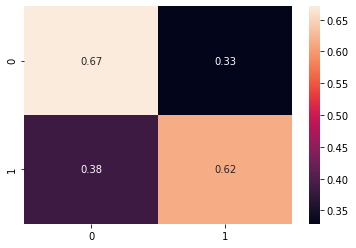

In [82]:
sns.heatmap(conf_mat, annot = True);

Вывод графика "полнота-точность":

In [83]:
probabilities = optimal_model_tree.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
p,r,t = precision_recall_curve(target_test, probabilities_one)

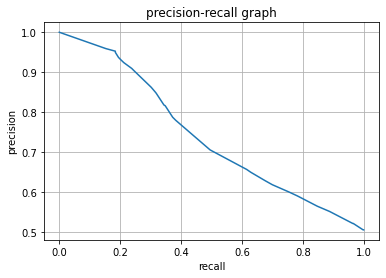

In [84]:
# Data for plotting
fig, ax = plt.subplots()
ax.plot(r, p)

ax.set(xlabel='recall', ylabel='precision',
       title='precision-recall graph')
ax.grid()

plt.show()

Анализ влияния фактора алкогольного опъянения на количество аварий (sql-запрос выполнен ранее):

In [85]:
data_collisions_alcohol

,count,party_sobriety
0,20975,"had been drinking, impairment unknown"
1,15967,"had been drinking, not under influence"
2,111559,"had been drinking, under influence"
3,1185724,had not been drinking
4,224079,impairment unknown
5,129640,not applicable
6,57946,None


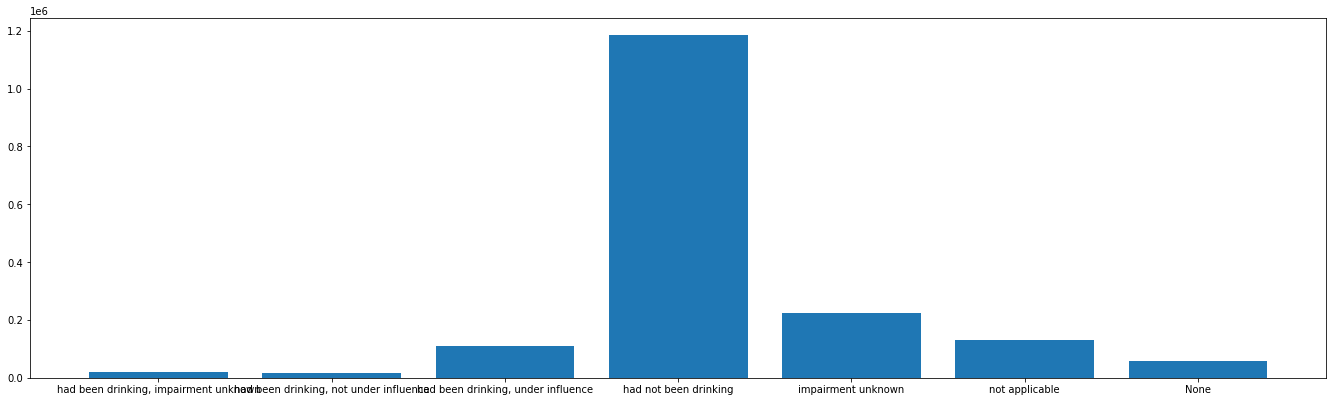

In [86]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_axes([0,0,1,1])
alcohol_factor = data_collisions_alcohol['party_sobriety'].astype(str)
collisions = data_collisions_alcohol['count']
ax.bar(alcohol_factor, collisions)
plt.show()

Диаграмма показывает, что если сложить пъяных водителей вместе, то они внесут существенный вклад в статистику ДТП. Но трезвых водителей попадает в ДТП все равно больше.

## Выводы

Для построения модели были отобраны пре-факторы, возможность которых можно оценить, когда водитель садится за руль. \
Вероятность попасть в аварию была заменена бинарной классификацией (прогноз попадет/не попадет). \
Наилучший показатель метрики f1 (64,4%) на бинарной класификации дает модель случайного дерева с глубиной 6 и числом листьев = 20. \ 
Самый важный фактор, влияющий на возможность аварии - состояние алкогольного опъянения (55%). Затем - воздействие лекарств (16%) и возраст автомобиля (14%). Тип автомобиля (7,5%). \
Состояние алкогольного опъянения водителя определить трудно. Необходимо проводить тест на алкоголь до начала движения. 
Для улучшения модели предлагается добавить статистику ДТП оцениваемого водителя, его возраст, стаж, заболевания, влияющие на реакцию.